In [1]:
import sys,os

import torch
import numpy as np

sys.path.append('..')

from modeling import SRNsModel
import util
from glob import glob

# _MODEL_DIR = '/root/liury/log/SRNs/060505face_celebA/checkpoints'
_MODEL_DIR = os.path.join(
    os.getenv("HOME"), 'liury/log/SRNs/061916face_celebA/checkpoints')
# _MODEL_PATH = '../checkpoints/050701face_seg_2000_depth.pth'

_LOG_ROOT = os.path.join(
    os.getenv("HOME"), 'liury/log/SRNs/061916face_celebA/reproj_celebA')
os.makedirs(os.path.join(_LOG_ROOT, 'vis'), exist_ok=True)

_TOT_NUM_INSTANCES = 50
# _TOT_NUM_INSTANCES = 3714

_IMG_SIZE = 128
_OUT_SIZE = 128

torch.cuda.set_device(1)

model = SRNsModel(num_instances=_TOT_NUM_INSTANCES,
                  latent_dim=256,
                  use_unet_renderer=False,
                  tracing_steps=10,
                  freeze_networks=True,
                  out_channels=20,
                  opt_cam=True,
                  img_sidelength=_IMG_SIZE,
                  output_sidelength=_OUT_SIZE
                 )

TypeError: __init__() got an unexpected keyword argument 'use_unet_renderer'

In [7]:
import numpy as np
from dataset.face_dataset import _campos2matrix
import cv2

from matplotlib import pyplot as plt

_CMAP = np.asarray([[0, 0, 0], [204, 0, 0], [76, 153, 0], [204, 204, 0], [51, 51, 255], [204, 0, 204], [0, 255, 255], [255, 204, 204], [102, 51, 0], 
                    [255, 0, 0], [102, 204, 0], [255, 255, 0], [0, 0, 153], [0, 0, 204], [255, 51, 153], [0, 204, 204], [0, 51, 0], [255, 153, 51], [0, 204, 0], [0, 204, 153]])

_CMAP =torch.tensor(_CMAP, dtype=torch.float32) / 255.0

def _build_cam_int(focal, H, W):
    return np.array([  [focal, 0., W // 2, 0.],
                       [0., focal, H // 2, 0],
                       [0., 0, 1, 0],
                       [0, 0, 0, 1]])


def render_scene(model, pose, z, focal, img_sidelength):
    
    with torch.no_grad():
        pose = torch.from_numpy(pose).float().unsqueeze(0)
        cam_int = torch.from_numpy(
            _build_cam_int(focal, _IMG_SIZE, _IMG_SIZE)).float().unsqueeze(0)

        uv = np.mgrid[0:_IMG_SIZE, 0:_IMG_SIZE].astype(np.int32)
        uv = torch.from_numpy(np.flip(uv, axis=0).copy()).long()
        uv = uv.reshape(2, -1).transpose(1, 0).unsqueeze(0)

#         print(pose.shape, cam_int.shape, uv.shape, z.shape)

        predictions, depth_maps = model(pose, z, cam_int, uv)

        pred = torch.argmax(predictions, dim=2, keepdim=True)

#         print(pred.shape)

        out_img = util.lin2img(pred, color_map=_CMAP).cpu().numpy()
        out_seg = pred.view(img_sidelength, img_sidelength, 1).cpu().numpy()
        
        out_img = (out_img.squeeze().transpose(1, 2, 0)) * 255.0
        out_img = out_img.round().clip(0, 255).astype(np.uint8)

#         output_fp = os.path.join(instance_dir, '%02d_seg.png'%(observation_idx))
        out_seg = out_seg.squeeze().astype(np.uint8)

#         plt.subplot(1, 2, 1)
#         plt.imshow(out_img)
#         plt.subplot(1, 2, 2)
#         plt.imshow(out_seg)

#         plt.show()

        torch.cuda.empty_cache()
        return out_img, out_seg

In [8]:
ckpt_fps = sorted(glob(os.path.join(_MODEL_DIR, '*.pth')))
print(ckpt_fps)

['/root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_0000_iter_000000.pth', '/root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_0142_iter_001000.pth', '/root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_0285_iter_002000.pth', '/root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_0428_iter_003000.pth', '/root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_0571_iter_004000.pth', '/root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_0714_iter_005000.pth', '/root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_0857_iter_006000.pth', '/root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_1000_iter_007000.pth', '/root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_1142_iter_008000.pth', '/root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_1285_iter_009000.pth', '/root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_1428_iter_010000.pth', '/root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_1571_iter_011000.pth', '/root/liury/log/SRNs/06191

Load model: /root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_0000_iter_000000.pth. epoch = 0, iter = 0
> output_dir:  /root/liury/log/SRNs/061916face_celebA/reproj_celebA/ckpt_000000


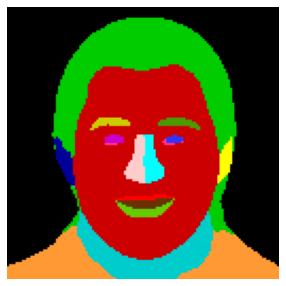

Load model: /root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_0142_iter_001000.pth. epoch = 142, iter = 1000
> output_dir:  /root/liury/log/SRNs/061916face_celebA/reproj_celebA/ckpt_001000


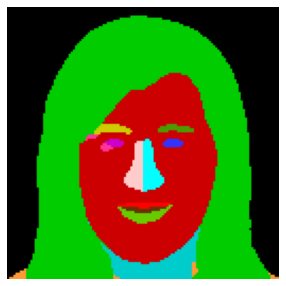

Load model: /root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_0285_iter_002000.pth. epoch = 285, iter = 2000
> output_dir:  /root/liury/log/SRNs/061916face_celebA/reproj_celebA/ckpt_002000


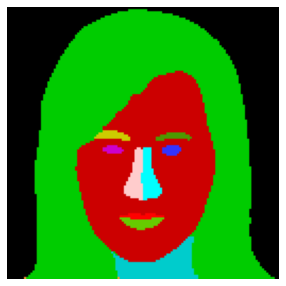

Load model: /root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_0428_iter_003000.pth. epoch = 428, iter = 3000
> output_dir:  /root/liury/log/SRNs/061916face_celebA/reproj_celebA/ckpt_003000


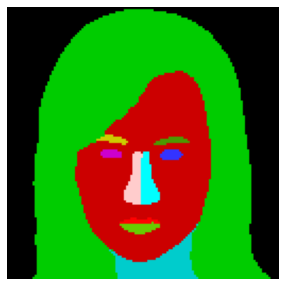

Load model: /root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_0571_iter_004000.pth. epoch = 571, iter = 4000
> output_dir:  /root/liury/log/SRNs/061916face_celebA/reproj_celebA/ckpt_004000


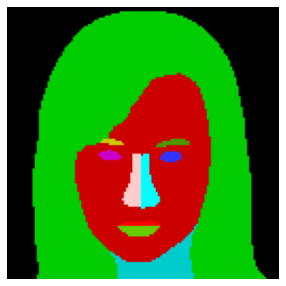

Load model: /root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_0714_iter_005000.pth. epoch = 714, iter = 5000
> output_dir:  /root/liury/log/SRNs/061916face_celebA/reproj_celebA/ckpt_005000


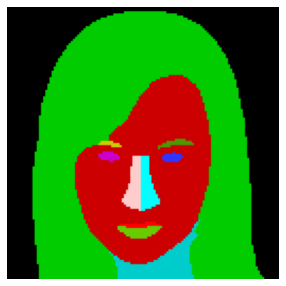

Load model: /root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_0857_iter_006000.pth. epoch = 857, iter = 6000
> output_dir:  /root/liury/log/SRNs/061916face_celebA/reproj_celebA/ckpt_006000


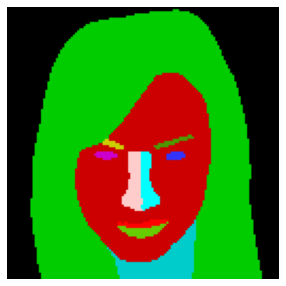

Load model: /root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_1000_iter_007000.pth. epoch = 1000, iter = 7000
> output_dir:  /root/liury/log/SRNs/061916face_celebA/reproj_celebA/ckpt_007000


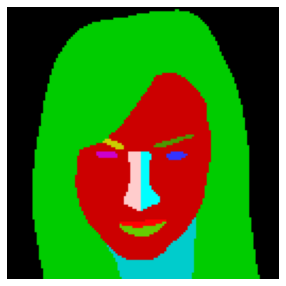

Load model: /root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_1142_iter_008000.pth. epoch = 1142, iter = 8000
> output_dir:  /root/liury/log/SRNs/061916face_celebA/reproj_celebA/ckpt_008000


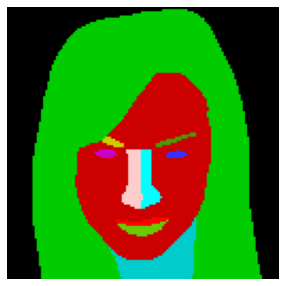

Load model: /root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_1285_iter_009000.pth. epoch = 1285, iter = 9000
> output_dir:  /root/liury/log/SRNs/061916face_celebA/reproj_celebA/ckpt_009000


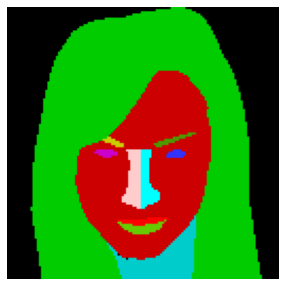

Load model: /root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_1428_iter_010000.pth. epoch = 1428, iter = 10000
> output_dir:  /root/liury/log/SRNs/061916face_celebA/reproj_celebA/ckpt_010000


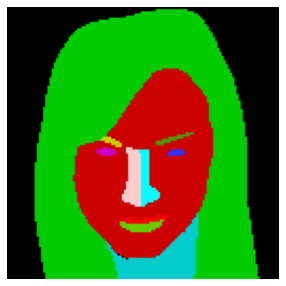

Load model: /root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_1571_iter_011000.pth. epoch = 1571, iter = 11000
> output_dir:  /root/liury/log/SRNs/061916face_celebA/reproj_celebA/ckpt_011000


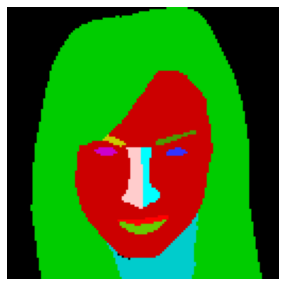

Load model: /root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_1714_iter_012000.pth. epoch = 1714, iter = 12000
> output_dir:  /root/liury/log/SRNs/061916face_celebA/reproj_celebA/ckpt_012000


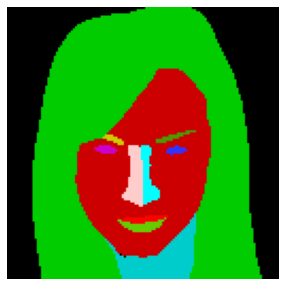

Load model: /root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_1857_iter_013000.pth. epoch = 1857, iter = 13000
> output_dir:  /root/liury/log/SRNs/061916face_celebA/reproj_celebA/ckpt_013000


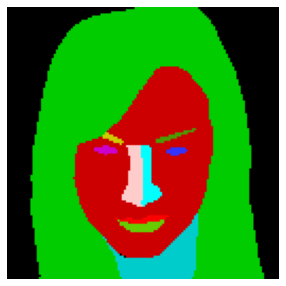

Load model: /root/liury/log/SRNs/061916face_celebA/checkpoints/epoch_2000_iter_014000.pth. epoch = 2000, iter = 14000
> output_dir:  /root/liury/log/SRNs/061916face_celebA/reproj_celebA/ckpt_014000


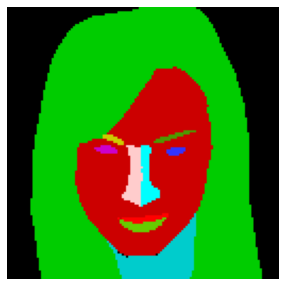

In [9]:
import random
import re

import imageio
import shutil

from dataset.face_dataset import _campos2matrix
from dataset import data_util

with open(os.path.join(_MODEL_DIR, '..', 'indexing.txt'), 'r') as f:
    gt_imgs = f.readlines()
    
    
_DEFAULT_CAM_INT = '../checkpoints/intrinsics.txt'
cam_int = data_util.parse_intrinsics(_DEFAULT_CAM_INT, trgt_sidelength=128)
focal = cam_int[0, 0]
cam_center = np.array([0,0.11,0.0])

# rand_idxs = random.choices(list(range(_TOT_NUM_INSTANCES)), k=30)

rand_idxs = list(range(_TOT_NUM_INSTANCES))
ins_idxs = [None] * len(rand_idxs)

ckpt_re = re.compile(r'^epoch_(\d+)_iter_(\d+).pth$')

output_dir = os.path.join(
            _LOG_ROOT, 'gt_segs')
os.makedirs(os.path.join(output_dir), exist_ok=True)

for idx, rand_idx in enumerate(rand_idxs):
    seg_fp = (gt_imgs[rand_idx]).strip()
    shutil.copyfile(
        seg_fp, os.path.join(output_dir, '%03d_%s'%(idx, os.path.basename(seg_fp))))
    ins_idxs[idx] = os.path.basename(seg_fp)
    
for ckpt_fp in ckpt_fps:
    util.custom_load(model, path=ckpt_fp, discriminator=None,
                 overwrite_embeddings=False, overwrite_cam=True)

    model.eval()
    model.cuda()
    
    m = ckpt_re.match(os.path.basename(ckpt_fp))
    if m:
        ckpt_epoch = int(m.group(1))
        ckpt_iter = int(m.group(2))
    
    print('Load model: %s. epoch = %d, iter = %d'%(ckpt_fp, ckpt_epoch, ckpt_iter))
    
    img_outputs = []    
    
    output_dir = os.path.join(
            _LOG_ROOT, 'ckpt_%06d'%(ckpt_iter))
    os.makedirs(output_dir, exist_ok=True)
    print('> output_dir: ', output_dir)    
    
    for idx, rand_idx in enumerate(rand_idxs):
        latent = model.get_embedding(
            {'instance_idx': torch.LongTensor([rand_idx]).squeeze().cuda()}).unsqueeze(0)        
        cam_T = (latent[:, :3]).clone().detach().squeeze().cpu().numpy()
        R = np.linalg.norm(cam_T)

        cam_pose = _campos2matrix(cam_T+cam_center, cam_center)
        out_img, out_seg = render_scene(model, cam_pose, latent, focal, _OUT_SIZE)
        
        img_outputs.append(out_img)
        output_fp = os.path.join(output_dir, '%03d_%s'%(idx, ins_idxs[idx]))
        util.write_img(out_seg, output_fp)

    imageio.mimsave(os.path.join(_LOG_ROOT, 'vis', '%06d.gif'%ckpt_iter), img_outputs, fps=5.0)
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(out_img)
    plt.axis('off')
    plt.show()